In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # Global features
        self.global_features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 128)
        )
        # Local features with adaptive pooling
        self.local_features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((8, 8))  # downsample to 8x8
        )

    def forward(self, x):
        return self.global_features(x), self.local_features(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Adjust the combined linear input size
        self.combine = nn.Sequential(
            nn.Linear(192, 512),  # Adjusted input size
            nn.ReLU(),
            nn.Linear(512, 1)  # Binary classification: real or fake
        )

    def forward(self, global_features, local_features):
        # Tile global features to have spatial dimensions of [8, 8]
        global_features_tiled = global_features.unsqueeze(2).unsqueeze(3).repeat(1, 1, 8, 8)
        combined = torch.cat([global_features_tiled, local_features], dim=1)
        combined = combined.view(combined.size(0) * combined.size(2) * combined.size(3), -1)  # Reshape for linear layers
        return self.combine(combined).squeeze()




In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import numpy as np
import matplotlib.pyplot as plt  # Make sure this line is included
from torch import nn, optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

# Data preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
unlabeled_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
unlabeled_dataloader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)
discriminator = Discriminator().to(device)

encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)
encoder_scheduler = StepLR(encoder_optimizer, step_size=10, gamma=0.7)
discriminator_scheduler = StepLR(discriminator_optimizer, step_size=10, gamma=0.7)
criterion = nn.BCEWithLogitsLoss()




Files already downloaded and verified


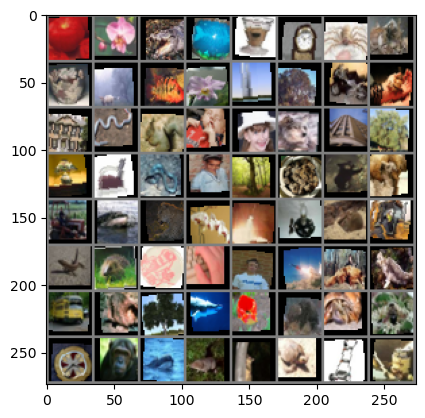

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision  # Make sure to import torchvision

# Take a batch of data and convert it to grid
dataiter = iter(unlabeled_dataloader)
images, _ = dataiter.__next__()  # Changed this line
grid = torchvision.utils.make_grid(images)

# Function to un-normalize and display the image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display
imshow(grid)



In [4]:
num_epochs = 50
losses = []  # Add this before the training loop

for epoch in range(num_epochs):
    for images, _ in unlabeled_dataloader:
        images = images.to(device)
        global_features, local_features = encoder(images)

        # Positive samples: local and global features from the same image
        positive_labels = torch.ones(local_features.size(0) * local_features.size(2) * local_features.size(3), device=device)
        positive_predictions = discriminator(global_features, local_features)

        # Negative samples: mix local features and global features
        negative_labels = torch.zeros(local_features.size(0) * local_features.size(2) * local_features.size(3), device=device)
        negative_predictions = discriminator(global_features[torch.randperm(local_features.size(0))], local_features)

        # Compute loss and update weights
        loss_positive = criterion(positive_predictions, positive_labels)
        loss_negative = criterion(negative_predictions, negative_labels)

        loss = loss_positive + loss_negative
        losses.append(loss.item())


        encoder_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()
        loss.backward()
        encoder_optimizer.step()
        discriminator_optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")



Epoch 1/50, Loss: 1.3702987432479858
Epoch 2/50, Loss: 1.365684986114502
Epoch 3/50, Loss: 1.367389440536499
Epoch 4/50, Loss: 1.3729774951934814
Epoch 5/50, Loss: 1.376417875289917
Epoch 6/50, Loss: 1.3718626499176025
Epoch 7/50, Loss: 1.3652777671813965
Epoch 8/50, Loss: 1.3665225505828857
Epoch 9/50, Loss: 1.3709142208099365
Epoch 10/50, Loss: 1.3686308860778809
Epoch 11/50, Loss: 1.3665757179260254
Epoch 12/50, Loss: 1.367845058441162
Epoch 13/50, Loss: 1.3652583360671997
Epoch 14/50, Loss: 1.3714208602905273
Epoch 15/50, Loss: 1.3685202598571777
Epoch 16/50, Loss: 1.3771660327911377
Epoch 17/50, Loss: 1.3653039932250977
Epoch 18/50, Loss: 1.370787501335144
Epoch 19/50, Loss: 1.36818528175354
Epoch 20/50, Loss: 1.3649859428405762
Epoch 21/50, Loss: 1.3714606761932373
Epoch 22/50, Loss: 1.3800382614135742
Epoch 23/50, Loss: 1.368937373161316
Epoch 24/50, Loss: 1.378041386604309
Epoch 25/50, Loss: 1.3678309917449951
Epoch 26/50, Loss: 1.364892601966858
Epoch 27/50, Loss: 1.3691434860

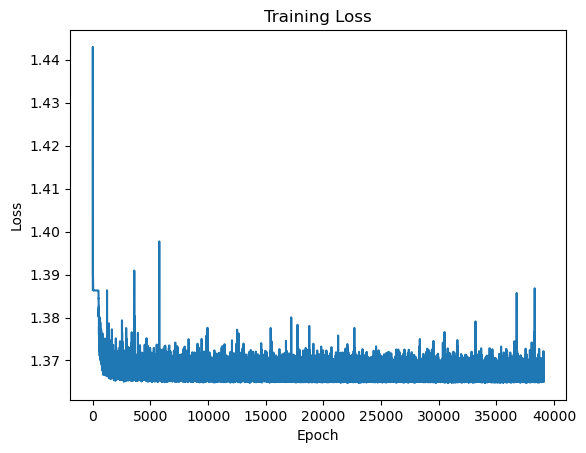

In [5]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [6]:
##used MLP

losses_1 = []
class Classifier(nn.Module):
    def __init__(self, num_classes=100):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(128, 512),  # Increased the number of neurons
            nn.ReLU(),
            nn.Dropout(p=0.5),   # Added dropout for regularization
            nn.Linear(512, 256), # Added an additional hidden layer
            nn.ReLU(),
            nn.Dropout(p=0.5),   # Added another dropout layer
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.network(x)

# Unfreeze encoder parameters for fine-tuning
for param in encoder.parameters():
    param.requires_grad = True


classifier = Classifier().to(device)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=0.001)
classification_criterion = nn.CrossEntropyLoss()

labeled_dataloader = torch.utils.data.DataLoader(
    datasets.CIFAR100(root='./data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True
)

num_epochs_classifier = 50

for epoch in range(num_epochs_classifier):
    for images, labels in labeled_dataloader:
        images, labels = images.to(device), labels.to(device)
        global_features, _ = encoder(images)
        predictions = classifier(global_features)
        loss = classification_criterion(predictions, labels)

        losses_1.append(loss.item())

        classifier_optimizer.zero_grad()
        loss.backward()
        classifier_optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs_classifier}, Loss: {loss.item()}")





Files already downloaded and verified
Epoch 1/50, Loss: 4.309042453765869
Epoch 2/50, Loss: 4.3915815353393555
Epoch 3/50, Loss: 4.545733451843262
Epoch 4/50, Loss: 4.3015456199646
Epoch 5/50, Loss: 4.768063068389893
Epoch 6/50, Loss: 4.160468578338623
Epoch 7/50, Loss: 4.315271854400635
Epoch 8/50, Loss: 4.7057881355285645
Epoch 9/50, Loss: 4.310538291931152
Epoch 10/50, Loss: 4.153334617614746
Epoch 11/50, Loss: 4.3093366622924805
Epoch 12/50, Loss: 4.370265007019043
Epoch 13/50, Loss: 4.925168037414551
Epoch 14/50, Loss: 4.350980758666992
Epoch 15/50, Loss: 4.156400680541992
Epoch 16/50, Loss: 4.268660068511963
Epoch 17/50, Loss: 4.135933876037598
Epoch 18/50, Loss: 4.236472129821777
Epoch 19/50, Loss: 4.684443950653076
Epoch 20/50, Loss: 4.38826322555542
Epoch 21/50, Loss: 4.618163108825684
Epoch 22/50, Loss: 3.9101357460021973
Epoch 23/50, Loss: 4.330141067504883
Epoch 24/50, Loss: 4.152182102203369
Epoch 25/50, Loss: 4.445101261138916
Epoch 26/50, Loss: 4.431423664093018
Epoch 27

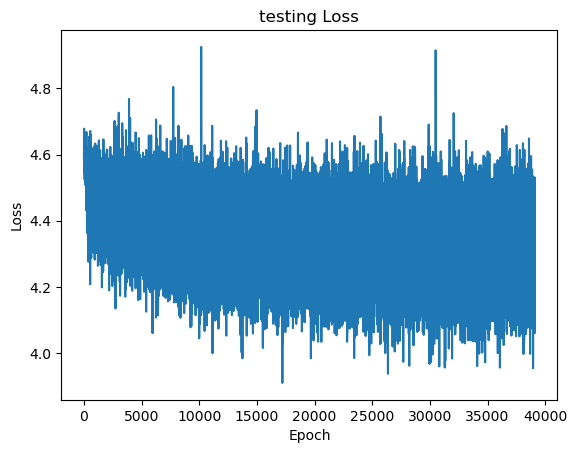

In [7]:
plt.plot(losses_1)
plt.title('testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [8]:
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

encoder.eval()
classifier.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        global_features, _ = encoder(images)
        predictions = classifier(global_features)
        _, predicted = torch.max(predictions.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct / total}%')





Files already downloaded and verified
Accuracy of the network on test images: 5.62%


/Users/sadianasrintisha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sadianasrintisha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sadianasrintisha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.03      0.05       100
           1       0.05      0.37      0.09       100
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.00      0.00      0.00       100
           6       0.03      0.16      0.05       100
           7       0.06      0.04      0.05       100
           8       0.00      0.00      0.00       100
           9       0.15      0.02      0.04       100
          10       0.00      0.00      0.00       100
          11       0.00      0.00      0.00       100
          12       0.00      0.00      0.00       100
          13       0.00      0.00      0.00       100
          14       0.01      0.01      0.01       100
          15       0.00      0.00      0.00       100
          16       0.18      0.12      0.14       100
    

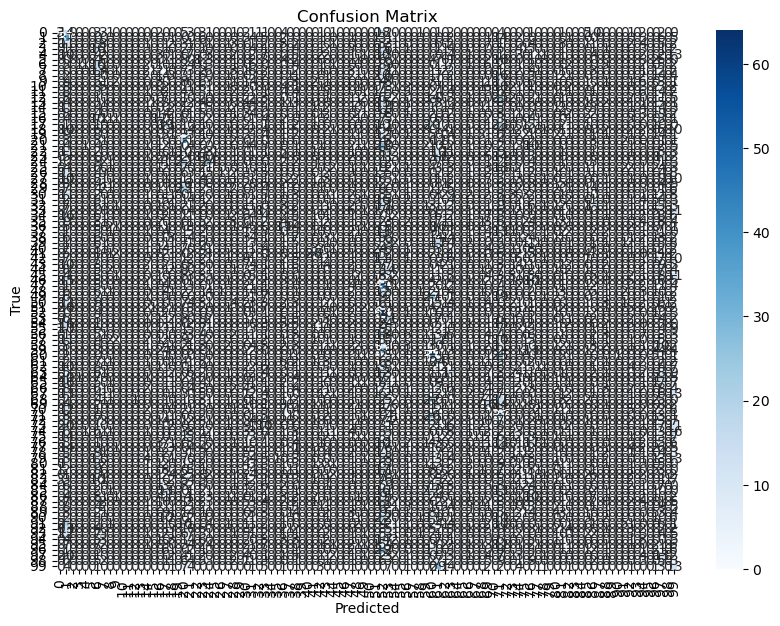

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Iterate over test data to get predictions and true labels
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        global_features, _ = encoder(images)
        predictions = classifier(global_features)
        _, predicted = torch.max(predictions.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the classification report and confusion matrix
report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(100)])  # Modify target_names with actual class names if needed
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print classification report
print("Classification Report:")
print(report)

# Plot confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=range(100), yticklabels=range(100))  # Modify xticklabels and yticklabels with actual class names if needed
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
